In [1]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2
from scipy.stats import spearmanr,pearsonr
from CCIT import CCIT


2022-09-22 06:41:49.934409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 06:41:49.934483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#defining the class MDN
class MDN_module(tf.keras.Model):
#changed from 15 to 20
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        #self.h1=Dense(12,activation="relu",name="h1")
        #self.h2=Dense(8,activation="relu",name="h2")
        #self.h3=Dense(8,activation="relu",name="h3")
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        #x=self.h3(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [3]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        #changing x to -1
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [4]:
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [5]:
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == 0]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [6]:
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [7]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    #eps0 = np.random.standard_normal(1000)
    #eps1 = np.random.standard_normal(1000)
    eps0 = np.random.normal(0,1,1000)
    eps1 = np.random.normal(0,1,1000)
    A = beta0 + beta1*L + eps0
    #B=beta2+beta3*np.sin(A)+eps1
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [8]:
fo=open("/home/aravind/projects/CIT_Non_Linear/LinearDifferentvalues/testing_writingvalues_Linear0to1.txt", "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,121):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [9]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(i < original for i in loss_list)/len(loss_list)
    
    

In [10]:
def compute_third_testloss(A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(A)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    return -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [11]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [12]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changing x== -1 
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        loss.append(calculate_difference(L,A,B_dist_temp))
    return loss

In [13]:
i=84
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])

Text(0, 0.5, 'B')

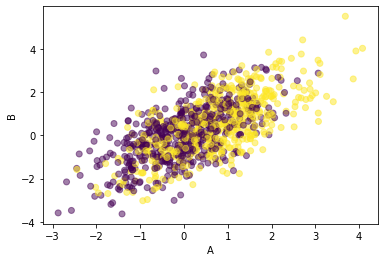

In [14]:
a=plt.scatter(A,B,c=L,alpha=0.5)
plt.xlabel("A")
plt.ylabel("B")

In [34]:
a.savefig('foo.png')

AttributeError: 'PathCollection' object has no attribute 'savefig'

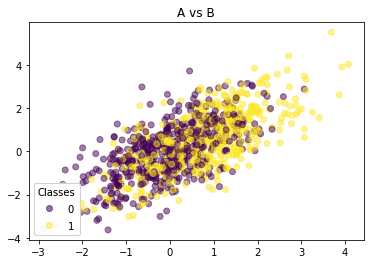

In [21]:

fig = plt.figure()
ax = plt.subplot(111)
scatter=ax.scatter(A,B,c=L,alpha=0.5)
plt.title('A vs B')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

#plt.show()
#plt.legend(handles=scatter.legend_elements()[0],labels=['0','1'])
fig.savefig('plot.png')

In [22]:
plt.show()

In [ ]:
#for i in range(0,144):
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])
shuffles=100
A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
#print("Original",B_shufflep
#changed the second test from mle to using neural networks
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
#loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test

true_LA=compute_loss(L,A,True)
true_LB=compute_loss(L,B,True)
loss_list_Bresidual,true_LBresidual= calculateLshuffle(L,A,B,shuffles)
#true_LBresidual=stratify_B_ntimes_permuteL(L,A,B,shuffles)
#true_LBresidual=calculate_difference(L,A,B)
#true_LBresidual=trueconditional(L,A,B)
#loss_list_Bresidual=stratify_B_ntimes_permuteL(L,A_shuffle,B_shuffle,shuffles)
#loss_list_Bresidual=stratify_B_ntimes_permuteL(L,A,B,shuffles,True)
LA_p=calculate_pvalue(true_LA,loss_list_LA)
LB_p=calculate_pvalue(true_LB,loss_list_LB)
AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
#AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
#mean_true=np.mean(true_LBresidual)
#mean_shuffle=np.mean(loss_list_Bresidual)
#std_true=np.std(true_LBresidual)
#std_shuffle=np.std(loss_list_Bresidual)
#f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(mean_true)+","+str(mean_shuffle)+","+str(std_true)+","+str(std_shuffle)+"\n")
#pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
#file_name=str(dataset_names[i])+".pkl"
#open_file = open("./DLresultspickle/"+file_name, "wb")
#pickle.dump(pickle_items, open_file)
#open_file.close()

#if(mean_shuffle>mean_true):
    #print(i)
    #count+=1


In [ ]:
LA_p=calculate_pvalue(true_LA,loss_list_LA)
LB_p=calculate_pvalue(true_LB,loss_list_LB)
AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)

In [ ]:
#function to calculate the original LA->B and then shuffle L and calculate the loss, we are retraining the model 
#at every shuffle here
def calculateLshuffle(L,A,B,shuffle):
    loss_list=[]
    opt = tf.optimizers.SGD(1e-3)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    withoutL=mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=32,verbose=0)
    y_pred = mdn_PQ.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alpha),
    components_distribution=tfd.Normal(
    loc=mu,       
    scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    orig_loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
    for i in range(shuffle):
        L_shuffle=np.random.permutation(L)
        opt = tf.optimizers.SGD(1e-3)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        withoutL=mdn_PQ.fit(x=np.concatenate([L_shuffle.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=32,verbose=0)
        y_pred = mdn_PQ.predict(np.concatenate([L_shuffle.reshape(-1,1),A.reshape(-1,1)],axis=1))
        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
        loc=mu,       
        scale=sigma))
        log_likelihood = gm.log_prob(B).numpy()
        loss= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
        loss_list.append(loss)
    
    return loss_list,loss

    

In [155]:
i=84
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])

In [15]:
def transfer(L,A,B,mdn_PQ):
    weightofa=mdn_PQ.layers[0].get_weights()[0][0]
    #get the bias
    biasweight=mdn_PQ.layers[0].get_weights()[1]
    #set the weights of L as zero 
    weightofL=np.zeros(15,dtype=np.float32)
    #combine the weights of L and A
    combinedweight=np.array([weightofL,weightofa])
    #combine the weights and biases
    layer0weightrans=[combinedweight,biasweight]
    #only for one epoch just to get the weights 
    opt = tf.optimizers.SGD(1e-3)
    mdn_trans = MDN_module()
    mdn_trans.compile(loss=gnll_loss, optimizer=opt)
    mdn_trans.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=1,  batch_size=32,verbose=0)
    y_pred = mdn_trans.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


    mdn_trans.layers[0].set_weights(layer0weightrans)

    a=mdn_PQ.layers[1].get_weights()
    mdn_trans.layers[1].set_weights(a)  
    a=mdn_PQ.layers[2].get_weights()
    mdn_trans.layers[2].set_weights(a)  
    a=mdn_PQ.layers[3].get_weights()
    mdn_trans.layers[3].set_weights(a)  
    a=mdn_PQ.layers[4].get_weights()
    mdn_trans.layers[4].set_weights(a)  
    a=mdn_PQ.layers[5].get_weights()
    mdn_trans.layers[5].set_weights(a)  
    return mdn_trans

In [16]:
#function to train the model given the inputs
def modeltrain(x,y,weights=None):
    opt = tf.optimizers.SGD(1e-3)
    
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    if(weights!=None):
        mdn_PQ.fit(x, y,epochs=1,batch_size = batchsize,verbose=0)
        for i in range(0,6):
            mdn_PQ.layers[i].set_weights(weights[i])
            
    #calculate the prediction and the loss 
    mdn_PQ.fit(x, y,epochs=epochs,batch_size=batchsize ,verbose=0)
    y_pred = mdn_PQ.predict(x)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,       
                scale=sigma))
    log_likelihood = gm.log_prob(y).numpy()
    loss_o = -tf.reduce_mean(log_likelihood, axis=-1).numpy()
    return mdn_PQ,loss_o

In [17]:
#function to calculate the weights 
def calculateweights(mdn_PQ):
    weights=[]
    weightofa=mdn_PQ.layers[0].get_weights()[0][0]
    #get the bias
    biasweight=mdn_PQ.layers[0].get_weights()[1]
    #set the weights of L as zero 
    weightofL=np.zeros(15,dtype=np.float32)
    #combine the weights of L and A
    combinedweight=np.array([weightofL,weightofa])
    #combine the weights and biases
    layer0weightrans=[combinedweight,biasweight]
    weights.append(layer0weightrans)
    for i in range(1,6):
        a=mdn_PQ.layers[i].get_weights()
        weights.append(a)
    return weights

In [18]:
#function to stratify the data
def stratifydata(L,B):
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    B_dist_temp=np.zeros(len(B))
    mod_indices_1=random.sample(indices_1,len(indices_1))
    for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

    mod_indices_0=random.sample(indices_0,len(indices_0))
    for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
    return B_dist_temp
    

In [19]:
#function to split the data
def splitdata(L,A,B):
    Aalone_L1=[]
    Aalone_L0=[]
    Balone_L1=[]
    Balone_L0=[]
    for i in range(len(L)):
        if(L[i]==1):
            Aalone_L1.append(A[i])
            Balone_L1.append(B[i])
        else:
            Aalone_L0.append(A[i])
            Balone_L0.append(B[i])
    
    return [np.array(Aalone_L1),np.array(Aalone_L0),np.array(Balone_L0),np.array(Balone_L1)]

In [29]:

epochs=100
batchsize=32


In [25]:
#checking one cycle 
def thirdtestonecycle(L,A,B):
    loss_Aalone=[]
    loss_AL=[]
    halfdata= splitdata(L,A,B)
    trainthirdtest(L,A,B,halfdata,loss_Aalone,loss_AL)
    trainthirdtest(L,A,B,halfdata,loss_Aalone,loss_AL,True,half=0)
    trainthirdtest(L,A,B,halfdata,loss_Aalone,loss_AL,True,half=1)
    trainthirdtest(L,A,B,halfdata,loss_Aalone,loss_AL,True)
    print("Loss with A alone: Loss A",loss_Aalone)
    print("Loss with A and L: Loss LA",loss_AL)
    a= 1 if min(loss_Aalone)-min(loss_AL) >=0 else 0
    return min(loss_Aalone)-min(loss_AL),a

In [111]:
las

In [183]:
AL=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1)
mdn1,loss1=modeltrain(reshapevar(A),B.T)

weights=calculateweights(mdn)
mdn2,loss2=modeltrain(AL,B.T,weights)

In [184]:
print("Loss wihtout L ",loss1)
print("Loss with L",loss2)

Loss wihtout L  1.464153
Loss with L 1.4353685


Text(0.5, 1.0, 'Loss with L 1.464153 Original data')

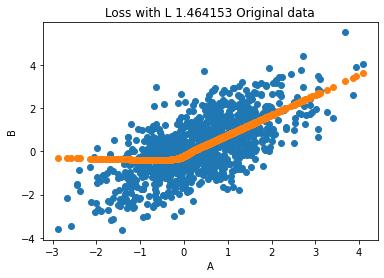

In [185]:
plt.scatter(A,B)
plt.scatter(A,mdn1.predict(reshapevar(A))[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Loss with L "+str(loss1)+" Original data")

Text(0.5, 1.0, 'Loss with L 1.4353685 Original data')

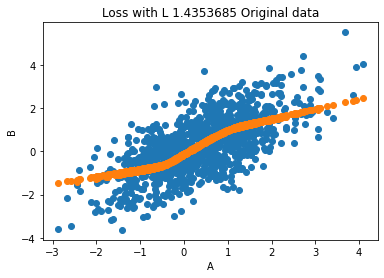

In [186]:
plt.scatter(A,B)
plt.scatter(A,mdn2.predict(AL)[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Loss with L "+str(loss2)+" Original data")

Loss wihtout L  1.7249472
Loss with L 1.7059531


In [193]:
B_perm=stratifydata(L,B)
AL=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1)
mdn1,loss1=modeltrain(reshapevar(A),B_perm.T)

weights=calculateweights(mdn)
mdn2,loss2=modeltrain(AL,B_perm.T,weights)

In [194]:
print("Loss wihtout L ",loss1)
print("Loss with L",loss2)

Loss wihtout L  1.7203071
Loss with L 1.7056738


Text(0.5, 1.0, 'Loss without L 1.7203071 Permuted data')

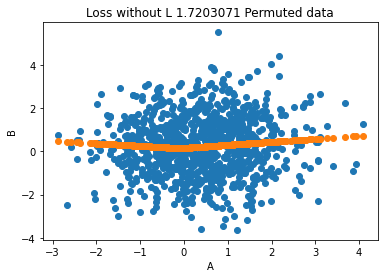

In [195]:
plt.scatter(A,B_perm)
plt.scatter(A,mdn1.predict(reshapevar(A))[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Loss without L "+str(loss1)+" Permuted data")

Text(0.5, 1.0, 'Loss with L 1.7056738 Permuted data')

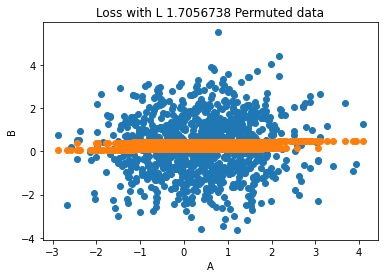

In [196]:
plt.scatter(A,B_perm)
plt.scatter(A,mdn2.predict(AL)[:,1])
plt.xlabel("A")
plt.ylabel("B")
plt.title("Loss with L "+str(loss2)+" Permuted data")

Text(0, 0.5, 'B')

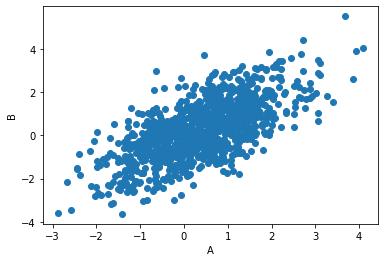

In [192]:
plt.scatter(A,B)
plt.xlabel("A")
plt.ylabel("B")

In [30]:
def thirdtestoriginal(L,A,B):
    print("Original data")
    print("Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer")
    loss,neg=thirdtestonecycle(L,A,B)
    print(" Difference(minimum from Loss A - minimum from Loss LA) ",loss)
    return loss,neg

In [31]:
def thirdtestperm(L,A,B,n):
    loss_perm=[]
    for i in range(0,n):
        print("Permutation ",i)
        print("Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer")
        B_perm=stratifydata(L,B)
        loss,neg=thirdtestonecycle(L,A,B_perm)
        print(" Difference(minimum from Loss A - minimum from Loss LA) ",loss)
        loss_perm.append(loss)
    return loss_perm

In [41]:
lorig=thirdtestoriginal(L,A,B)

Original data
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.4533767, 1.5196483, 1.4584725, 1.4277017]
Loss with A and L: Loss LA [1.4344414, 1.4262989, 1.4190271, 1.418967]
 Difference(minimum from Loss A - minimum from Loss LA)  0.008734703


In [53]:
loper=thirdtestperm(L,A,B,100)

Permutation  0
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7211455, 1.765429, 1.7274792, 1.7214354]
Loss with A and L: Loss LA [1.7156892, 1.7215366, 1.7175022, 1.7130249]
 Difference(minimum from Loss A - minimum from Loss LA)  0.008120656
Permutation  1
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7204468, 1.7473615, 1.7246672, 1.716168]
Loss with A and L: Loss LA [1.7082659, 1.7099652, 1.7161174, 1.7147708]
 Difference(minimum from Loss A - minimum from Loss LA)  0.007902145
Permutation  2
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.720013, 1.7339811, 1.7494407, 1.7201525]
Loss with A and L: Loss LA [1.7174639, 1.7149975, 1.7181653, 1.7151616]
 Difference(minimum from Loss A - minimum from Loss LA)  0.0050154924
Permutation  3
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7229211, 1.750484

Loss with A alone: Loss A [1.7232049, 1.744778, 1.7385792, 1.7231911]
Loss with A and L: Loss LA [1.7147938, 1.7181071, 1.7213286, 1.7202976]
 Difference(minimum from Loss A - minimum from Loss LA)  0.008397341
Permutation  29
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.721228, 1.7824637, 1.7364475, 1.7164394]
Loss with A and L: Loss LA [1.701051, 1.7153939, 1.7173824, 1.7151294]
 Difference(minimum from Loss A - minimum from Loss LA)  0.01538837
Permutation  30
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7283452, 1.7518632, 1.7306395, 1.7223262]
Loss with A and L: Loss LA [1.7130121, 1.7177228, 1.7121433, 1.7194293]
 Difference(minimum from Loss A - minimum from Loss LA)  0.0101828575
Permutation  31
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7197627, 1.7484944, 1.7331725, 1.7185462]
Loss with A and L: Loss LA [1.7135112, 1.7121582, 1.7

Loss with A alone: Loss A [1.723342, 1.7517949, 1.7274376, 1.7252256]
Loss with A and L: Loss LA [1.7142693, 1.7177463, 1.7237248, 1.7215791]
 Difference(minimum from Loss A - minimum from Loss LA)  0.009072661
Permutation  58
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7203271, 1.7409207, 1.7286489, 1.7206037]
Loss with A and L: Loss LA [1.7052948, 1.7174864, 1.7166916, 1.7163482]
 Difference(minimum from Loss A - minimum from Loss LA)  0.015032291
Permutation  59
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7244892, 1.7480559, 1.730793, 1.7204106]
Loss with A and L: Loss LA [1.7140708, 1.7192963, 1.7163117, 1.7132967]
 Difference(minimum from Loss A - minimum from Loss LA)  0.0071139336
Permutation  60
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7218148, 1.7433113, 1.7304804, 1.7181336]
Loss with A and L: Loss LA [1.7065498, 1.718275, 1.

Loss with A alone: Loss A [1.7208354, 1.7415024, 1.7298248, 1.7202548]
Loss with A and L: Loss LA [1.7167156, 1.7117391, 1.7151234, 1.7168182]
 Difference(minimum from Loss A - minimum from Loss LA)  0.008515716
Permutation  87
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7210358, 1.7482216, 1.7280008, 1.7215002]
Loss with A and L: Loss LA [1.7142851, 1.7135136, 1.713751, 1.7168394]
 Difference(minimum from Loss A - minimum from Loss LA)  0.0075222254
Permutation  88
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7157615, 1.7637085, 1.7385316, 1.7293959]
Loss with A and L: Loss LA [1.7108396, 1.7162703, 1.7115474, 1.7216687]
 Difference(minimum from Loss A - minimum from Loss LA)  0.004921913
Permutation  89
Loss Order: Random,L=0 tranfer, L= 1 tranfer, Full data transfer
Loss with A alone: Loss A [1.7244627, 1.744829, 1.7340293, 1.7226834]
Loss with A and L: Loss LA [1.7150633, 1.7155629, 1

In [54]:
loper

[0.008120656,
 0.007902145,
 0.0050154924,
 0.0216465,
 0.008078814,
 0.008609176,
 0.013999939,
 0.0059826374,
 0.0093199015,
 0.0070023537,
 0.017028451,
 0.011233568,
 0.011437893,
 0.00800395,
 0.0066559315,
 0.014075756,
 0.0054831505,
 0.008024454,
 0.006153822,
 0.009674072,
 0.0030277967,
 0.009283185,
 0.0077342987,
 0.0062949657,
 0.011068702,
 0.014976859,
 0.018102884,
 0.0060317516,
 0.008397341,
 0.01538837,
 0.0101828575,
 0.006387949,
 0.008796096,
 0.005020261,
 0.007627368,
 0.008945823,
 0.016292453,
 0.016316652,
 0.0073610544,
 0.011003852,
 0.011715651,
 0.007461667,
 0.0059274435,
 0.012510538,
 0.016274571,
 0.008564949,
 0.004344225,
 0.020432234,
 0.00662899,
 0.019727468,
 0.0096770525,
 0.0034928322,
 0.006540656,
 0.006096959,
 0.018046856,
 0.007998347,
 0.011338949,
 0.009072661,
 0.015032291,
 0.0071139336,
 0.011583805,
 0.019781351,
 0.0071798563,
 0.0062212944,
 0.01186955,
 0.01036191,
 0.008970618,
 0.012630343,
 0.020332217,
 0.0053400993,
 0.00488

In [55]:
lorig[0]

0.008734703

In [57]:
tes=[1 if i<lorig[0]  else 0 for i in loper  ]

In [58]:
sum(tes)

47

In [33]:
#function to train the data for each configuration 
def trainthirdtest(L,A,B,halfdata,loss_Aalone,loss_AL,transfer=False,half=None):
    AL=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1)
    if half==None:
        mdn,loss=modeltrain(reshapevar(A),B.T)
        loss_Aalone.append(loss)
        weights=None
        if transfer==True :
            weights=calculateweights(mdn)
        mdn,loss=modeltrain(AL,B.T,weights)
        loss_AL.append(loss)
    elif half==1:
        Aalone_L1=halfdata[0]
        Balone_L1=halfdata[3]
        mdn,loss=modeltrain(reshapevar(Aalone_L1),Balone_L1.T)
        y_pred = mdn.predict(reshapevar(A))
        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,       
                scale=sigma))
        log_likelihood = gm.log_prob(B.T).numpy()
        loss_o = -tf.reduce_mean(log_likelihood, axis=-1).numpy()
        loss_Aalone.append(loss_o)
        weights=None
        if transfer==True :
            weights=calculateweights(mdn)
        mdn,loss=modeltrain(AL,B.T,weights)
        loss_AL.append(loss)
    elif half==0:
        Aalone_L0=halfdata[1]
        Balone_L0=halfdata[2]
        mdn,loss=modeltrain(reshapevar(Aalone_L0),Balone_L0.T)
        y_pred = mdn.predict(reshapevar(A))
        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
        log_likelihood = gm.log_prob(B.T).numpy()
        loss_o = -tf.reduce_mean(log_likelihood, axis=-1).numpy()
        loss_Aalone.append(loss_o)
        weights=None
        if transfer==True :
            weights=calculateweights(mdn)
        mdn,loss=modeltrain(AL,B.T,weights)
       
        loss_AL.append(loss)
    

In [ ]:
def transferweights(L,A,B,n):
    #train the A->B model
    opt = tf.optimizers.SGD(1e-3)
    mdn_PQ = MDN_module()
    #calculate the prediction and the loss 
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    withoutL=mdn_PQ.fit(x=reshapevar(A), y=B.T,epochs=100,batch_size=32,verbose=0)
    y_pred = mdn_PQ.predict(reshapevar(A))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,       
                scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    loss_o = -tf.reduce_mean(log_likelihood, axis=-1).numpy()
    #get the weights of A
    weightofa=mdn_PQ.layers[0].get_weights()[0][0]
    #get the bias
    biasweight=mdn_PQ.layers[0].get_weights()[1]
    #set the weights of L as zero 
    weightofL=np.zeros(15,dtype=np.float32)
    #combine the weights of L and A
    combinedweight=np.array([weightofL,weightofa])
    #combine the weights and biases
    layer0weightrans=[combinedweight,biasweight]
    #only for one epoch just to get the weights 
    opt = tf.optimizers.SGD(1e-3)
    mdn_trans = MDN_module()
    mdn_trans.compile(loss=gnll_loss, optimizer=opt)
    mdn_trans.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=1,  batch_size=32,verbose=0)
    y_pred = mdn_trans.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


    mdn_trans.layers[0].set_weights(layer0weightrans)

    a=mdn_PQ.layers[1].get_weights()
    mdn_trans.layers[1].set_weights(a)  
    a=mdn_PQ.layers[2].get_weights()
    mdn_trans.layers[2].set_weights(a)  
    a=mdn_PQ.layers[3].get_weights()
    mdn_trans.layers[3].set_weights(a)  
    a=mdn_PQ.layers[4].get_weights()
    mdn_trans.layers[4].set_weights(a)  
    a=mdn_PQ.layers[5].get_weights()
    mdn_trans.layers[5].set_weights(a)  
    #after setting the weights train it for 100 epochs with L also as input
    mdn_trans.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B.T,epochs=100,  batch_size=32,verbose=0)
    y_pred = mdn_trans.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.Normal(
                loc=mu,       
                scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    loss_o_L= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
    trueloss= loss_o-loss_o_L

    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]


        #train A-> Bstratified 
        opt = tf.optimizers.SGD(1e-3)
        mdn_PQ = MDN_module()

        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(A), y=B_dist_temp.T,epochs=100,batch_size=32,verbose=0)
        y_pred = mdn_PQ.predict(reshapevar(A))

        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=alpha),
                components_distribution=tfd.Normal(
                    loc=mu,       
                    scale=sigma))
        log_likelihood = gm.log_prob(B_dist_temp).numpy()
        loss_o_strat= -tf.reduce_mean(log_likelihood, axis=-1).numpy()

        #get the weights of A
        weightofa=mdn_PQ.layers[0].get_weights()[0][0]
        #get the bias
        biasweight=mdn_PQ.layers[0].get_weights()[1]
        #set the weights of L as zero 
        weightofL=np.zeros(15,dtype=np.float32)
        #combine the weights of L and A
        combinedweight=np.array([weightofL,weightofa])
        #combine the weights and biases
        layer0weightrans=[combinedweight,biasweight]

        #only for one epoch just to get the weights 
        opt = tf.optimizers.SGD(1e-3)
        mdn_trans = MDN_module()
        mdn_trans.compile(loss=gnll_loss, optimizer=opt)
        mdn_trans.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=1,  batch_size=32,verbose=0)
        y_pred = mdn_trans.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))


        mdn_trans.layers[0].set_weights(layer0weightrans)

        a=mdn_PQ.layers[1].get_weights()
        mdn_trans.layers[1].set_weights(a)  
        a=mdn_PQ.layers[2].get_weights()
        mdn_trans.layers[2].set_weights(a)  
        a=mdn_PQ.layers[3].get_weights()
        mdn_trans.layers[3].set_weights(a)  
        a=mdn_PQ.layers[4].get_weights()
        mdn_trans.layers[4].set_weights(a)  
        a=mdn_PQ.layers[5].get_weights()
        mdn_trans.layers[5].set_weights(a)  
        #train it for 100 epochs after setting the weights 

        mdn_trans.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1), y=B_dist_temp.T,epochs=100,  batch_size=32,verbose=0)
        y_pred = mdn_trans.predict(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1))

        alpha,mu,sigma = slice_parameter_vectors(y_pred)
        gm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=alpha),
                components_distribution=tfd.Normal(
                    loc=mu,       
                    scale=sigma))
        log_likelihood = gm.log_prob(B_dist_temp).numpy()
        loss_o_strat_L= -tf.reduce_mean(log_likelihood, axis=-1).numpy()
        loss.append(loss_o_strat-loss_o_strat_L)
    return trueloss,loss

In [ ]:
n=100
t,l=transferweights(L,A,B,n)